# Vortex Sheet Roll-up

In [1]:
using VortexModel

## Set up plotting

The specifics of how we plot the figures are not important.  We will be using [`Gadfly`](https://github.com/GiovineItalia/Gadfly.jl), but you can use any plotting package you like.

In [2]:
using Gadfly
Gadfly.push_theme(Theme(line_width = 1px, grid_line_width=0mm))
function plot_sheet(sheet)
    plot(x = real.(sheet.zs), y = imag.(sheet.zs),
         Geom.line(preserve_order=true),
         style(default_color=colorant"#1f77b4"),
         Coord.Cartesian(fixed=true))
end

plot_sheet (generic function with 1 method)

Alternatively, you can also use [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl) as follows:
```julia
using PyPlot
function plot_sheet(sheet; kwargs...)
    zs = getfield.(sheet.blobs, :z)
    plot(real.(zs), imag.(zs); kwargs...)
    axis(:scaled)
end
```

## Initializing the sheet

We want to recreate the simulation of a vortex sheet roll-up as presented in [Krasny 1987: Computation of vortex sheet roll-up in the Trefftz plane](https://doi.org/10.1017/S0022112087002830).
The discretization parameters are listed below:

In [3]:
N = 200
α = linspace(0, π, 2N+1)
zs = complex.(cos.(α))
Γs = sin.(α)
δ = 0.05;
Δt = 0.01;

We can initialize the vortex sheet by providing it with a list of control points `zs`, the circulation from the tip of the sheet `zs[1]` to any subsequent control point, and a blob radius.

In order to use the time marching schemes defined in `src/TimeMarching.jl`, we define `compute_ẋ!` that computes the velocities of the sheet control points:

In [4]:
function compute_ẋ!(ẋ, x, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x)
end

compute_ẋ! (generic function with 1 method)

## Time Marching

We start by using forward-Euler:

In [5]:
sheet = Vortex.Sheet(zs, Γs, δ)
w = allocate_velocity(sheet);

for t in 0.0:Δt:1.0
    forward_euler!(sheet, sheet, t, Δt, compute_ẋ!, advect!, w)
    # which does the same thing as:
    #     reset_velocity!(w, sheet)
    #     self_induce_velocity!(w, sheet)
    #     advect!(sheet, sheet, w, Δt)
end

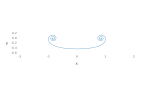

In [6]:
plot_sheet(sheet)

which seems to work just fine.  But over a longer time interval, instabilities in the sheet start to show, resulting in sheet segments that overlap with each other:

In [7]:
for t in 1.01:Δt:4.0
    forward_euler!(sheet, sheet, t, Δt, compute_ẋ!, advect!, w)
end

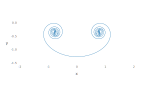

In [8]:
plot_sheet(sheet)

If we use 4th-order Runge-Kutta, as was done in [Krasny 1987](https://doi.org/10.1017/S0022112087002830), we obtain:  

In [9]:
sheet  = Vortex.Sheet(zs, Γs, δ)
sheet₊ = deepcopy(sheet)

ẋs = [allocate_velocity(sheet) for k in 1:4]
for t in 0:Δt:4.0
    rk4!(sheet₊, sheet, t, Δt, compute_ẋ!, advect!, ẋs)
    sheet₊, sheet = sheet, sheet₊
end

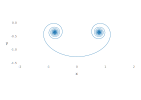

In [10]:
plot_sheet(sheet)

The higher order time-marching scheme gives us a more stable vortex core, but the large strain-rates start to reveal the discrete nature of our vortex sheet.

Another way we can supress the instabilities is to use discrete Fourier transforms to directly filter out any length scales in the sheet below a specified threshold.  As an added benefit, the filtering process automatically inserts and redistributes control points to maintain a uniform particle density along the sheet.

Here, we will filter out any distrubances with length scales greater than 0.4 times the blob radius and redistribute the control points so that there are 5 control points within a blob radius.  If we use forward-Euler with filtering, we have:

In [11]:
sheet₊ = Vortex.Sheet(zs, Γs, δ)
ẋ = allocate_velocity(sheet)
for t in 0:Δt:4.0
    forward_euler!(sheet₊, sheet₊, t, Δt, compute_ẋ!, advect!, ẋ)
    z₌, Γ₌, l = Vortex.Sheets.remesh(sheet₊, 0.2δ)
    Vortex.Sheets.filter_position!(z₌, 0.4δ, l)
    Vortex.Sheets.redistribute_points!(sheet₊, z₌, Γ₌)
end

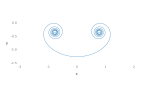

In [12]:
plot_sheet(sheet₊)

and if we use 4th-order Runge-Kutta, we get:

In [13]:
sheet₋ = Vortex.Sheet(zs, Γs, δ)
sheet₊ = deepcopy(sheet₋)

ẋs = [allocate_velocity(sheet₋) for k in 1:4]
for t in 0:Δt:4.0
    rk4!(sheet₊, sheet₋, t, Δt, compute_ẋ!, advect!, ẋs)
    Vortex.Sheets.filter!(sheet₊, 0.2δ, 0.4δ)
    sheet₊, sheet₋ = sheet₋, sheet₊
end

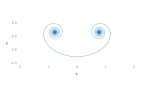

In [14]:
plot_sheet(sheet₋)

The continuity of the sheet comes at the cost of increased particle count.  Before filtering, we have:

In [15]:
length(sheet.blobs)

401

with filtering, we have:

In [16]:
length(sheet₊.blobs)

1661